## **IMPORT DATASET**

importing and mounting Google Drive so we can access the dataset ZIP file stored in our drive.

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


unzip the file

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/shl-intern-hiring-assessment.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
TRAIN_CSV = "/content/dataset/train.csv"
TEST_CSV = "/content/dataset/test.csv"
TRAIN_AUDIO_DIR = "/content/dataset/audios_train"
TEST_AUDIO_DIR = "/content/dataset/audios_train"

## **NECESSARY LIBRARIES AND MODULES**

#### System and Data Handling
- `os`  
  Used for file and directory operations (e.g., navigating file paths for audio files).

- `numpy as np`  
  A core library for numerical computations and array manipulations.

- `pandas as pd`  
  Essential for reading CSV files, handling tabular data (like labels, filenames), and dataframe operations.

---

#### Audio Processing
- `librosa`  
  A powerful library for audio and music analysis. It's used for:
  - Loading `.wav` audio files
  - Extracting features like MFCC
  - Audio augmentation (e.g., trimming silence, time-stretching)

---

#### Data Preprocessing and Splitting
  
  Splits the dataset into training and validation sets for model evaluation.

- `StandardScaler`  
  Standardizes features by removing the mean and scaling to unit variance — especially useful for ML/DL models.

- `resample`  
  Helps in balancing the dataset by oversampling underrepresented classes.



#### Deep Learning (Modeling)

  TensorFlow is the deep learning framework used here.

- `Sequential`  
  Allows building models layer-by-layer using a sequential architecture.

- ` Dense, LSTM, Bidirectional, Dropout`  
  - `Dense`: Fully connected layer for prediction.
  - `LSTM`: Long Short-Term Memory layer, good for sequential data like audio.
  - `Bidirectional`: Runs LSTM forward and backward to capture more context.
  - `Dropout`: Regularization technique to prevent overfitting by randomly dropping neurons.



#### Visualization
- ` matplotlib`  
  For visualizing training metrics (loss, accuracy), audio signals, or confusion matrices.

- ` seaborn `  
  Statistical data visualization library — especially helpful for heatmaps and better plots.


In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
import matplotlib.pyplot as plt


In [ ]:
import seaborn as sns

In [ ]:
df = pd.read_csv(TRAIN_CSV)

## **ANALYSIS**

In [ ]:
df.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


- `info()`: Provides metadata about the dataset.
  - Total entries: 444
  - Columns: 2
    - `filename` (object type)
    - `label` (float64)
  - No missing values in any column, which means data is clean and ready for processing.

- `unique()`: Displays the unique labels (target values) present in the dataset.  
  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  444 non-null    object 
 1   label     444 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.1+ KB


In [ ]:
df['label'].unique()

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4.5, 4. , 5. ])

In [ ]:
score_counts = df['label'].value_counts().sort_index()

In [ ]:
print(score_counts )

label
1.0      1
1.5      3
2.0     70
2.5     40
3.0     87
3.5     23
4.0     52
4.5     58
5.0    110
Name: count, dtype: int64


<ipython-input-21-007308cf0c0b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index, y=score_counts.values, palette="mako")


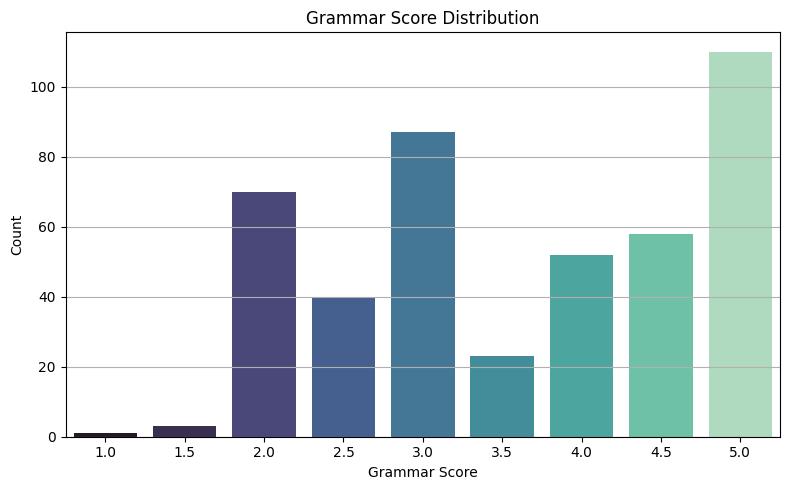

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x=score_counts.index, y=score_counts.values, palette="mako")
plt.title("Grammar Score Distribution")
plt.xlabel("Grammar Score")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
durations = []
for filename in df['filename']:
    file_path = os.path.join(TRAIN_AUDIO_DIR, filename)
    try:
        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
    except:
        durations.append(None)


In [ ]:
df['duration'] = durations

In [ ]:
df = df.dropna()

In [ ]:
df['duration'].describe()

,duration
count,444.000000
mean,76.245152
std,42.380392
min,20.120000
25%,60.074688
50%,60.074688
75%,60.080000
max,182.208000


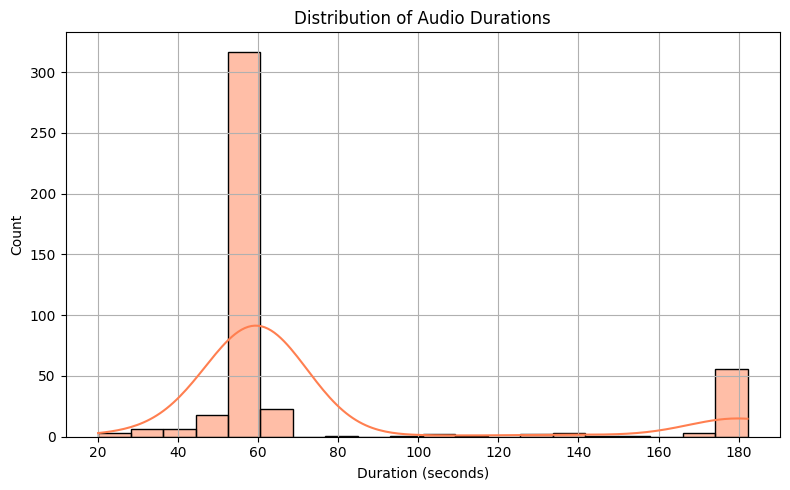

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['duration'], bins=20, kde=True, color="coral")
plt.title("Distribution of Audio Durations")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-27-1428c2d69d7b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='duration', data=df, palette="Set2")


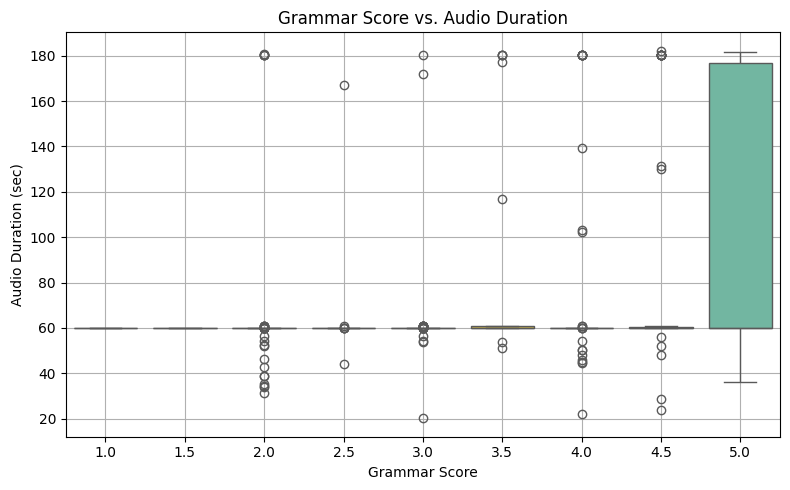

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='duration', data=df, palette="Set2")
plt.title("Grammar Score vs. Audio Duration")
plt.xlabel("Grammar Score")
plt.ylabel("Audio Duration (sec)")
plt.grid(True)
plt.tight_layout()
plt.show()

## **PREPROCESSING**

Before training a model, it's crucial to ensure that the dataset is balanced. This prevents the model from becoming biased toward labels that are more frequent.

In [ ]:
#FUNTION FOR BALANCE DATASET
def balance_dataset(df):
    balanced_df = pd.DataFrame()
    for score in df['label'].unique():
        samples = df[df['label'] == score]
        if len(samples) < 50:  # adjust threshold
            samples = resample(samples, replace=True, n_samples=50, random_state=42)
        balanced_df = pd.concat([balanced_df, samples])
    return balanced_df.sample(frac=1).reset_index(drop=True)

df = balance_dataset(df)

## **FEATURE EXTRACTION**

In [ ]:
SAMPLE_RATE = 16000
max_len = 500

1. **Audio Loading**  
   Loads the audio file using `librosa.load()`.

2. **Silence Removal**  
   Removes leading and trailing silence using `librosa.effects.trim()` (based on decibel threshold).

3. **Volume Normalization**  
   Scales audio to a range of **[-1, 1]** using `np.max()` to ensure consistent amplitude across all samples.

4. **MFCC Feature Extraction**
   - `mfcc`: Extracts **Mel-Frequency Cepstral Coefficients** (n=13) – a compact representation of audio.
   - `delta`: First derivative of MFCC (captures change over time).
   - `delta2`: Second derivative (captures acceleration/trends).

5. **Combine Features**
   Concatenates `[mfcc, delta, delta2]` into a single 2D array of shape (39, time_steps).

6. **Padding or Truncation**
   Ensures all feature arrays are of the same length `max_len`.
   - Pads with zeros if too short.
   - Truncates if too long.


In [ ]:
#FUNCTION REMOVE SILENCE ,VOLUME NORMALIZATION AND EXTRACT MFCC +DELTA MFCC+ DELTA2 MFCC FEATURE def extract_features(file_path, max_len=862):  # adjust max_len as per your model needs
    y, sr = librosa.load(file_path, sr=None)

    #Silence Removal
    y, _ = librosa.effects.trim(y, top_db=20)  # trims leading & trailing silence

    #  Volume Normalization
    y = y / np.max(np.abs(y))  # normalize waveform to [-1, 1]

    #  MFCC + delta + delta-delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    combined = np.concatenate([mfcc, delta, delta2], axis=0)

    # Padding or truncating
    if combined.shape[1] < max_len:
        pad_width = max_len - combined.shape[1]
        combined = np.pad(combined, ((0, 0), (0, pad_width)), mode='constant')
    else:
        combined = combined[:, :max_len]

    return combined

In [ ]:
from tqdm import tqdm

In [ ]:
X = []
y = []

print("Extracting features...")
for i, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(TRAIN_AUDIO_DIR, row['filename'])
    features= extract_features(file_path)
    X.append(features)
    y.append(row['label'])

Extracting features...


100%|██████████| 577/577 [00:59<00:00,  9.64it/s]


In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
print("Feature shape:", X.shape)

Feature shape: (577, 39, 862)


## **DATA SPLITING**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

## **LSTM MODEL BUILDING**

In [ ]:
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1)  # Regression output
])

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mae']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 39, 862)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 39, 64)              │         237,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 39, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 250,273 (977.63 KB)

 Trainable params: 250,273 (977.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16
)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 12.3406 - mae: 3.2352 - val_loss: 7.2924 - val_mae: 2.3010
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.6051 - mae: 1.9667 - val_loss: 1.5323 - val_mae: 1.0779
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5978 - mae: 1.0978 - val_loss: 1.0913 - val_mae: 0.8978
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3169 - mae: 0.9500 - val_loss: 0.9247 - val_mae: 0.7851
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9146 - mae: 0.7534 - val_loss: 0.9792 - val_mae: 0.7630
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5453 - mae: 0.5759 - val_loss: 0.9884 - val_mae: 0.7663
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3882 - mae: 0.4909 - val_loss: 0.9979 - val_mae: 0.7468
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4032 - mae: 0.4909 - val_loss: 1.0677 - val_mae: 0.7583
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.34

## **MODEL EVALUATION**

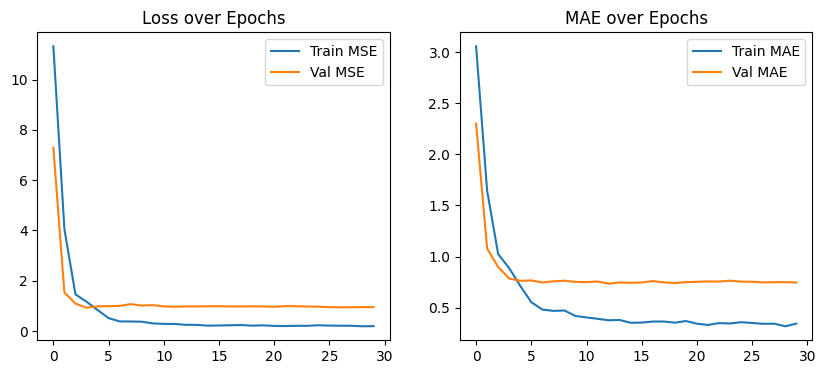

In [ ]:

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.legend()
plt.title("Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title("MAE over Epochs")
plt.show()

In [ ]:
val_loss, val_mae = model.evaluate(X_val, y_val)
print(f"Validation MAE: {val_mae:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9367 - mae: 0.7422
Validation MAE: 0.75


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


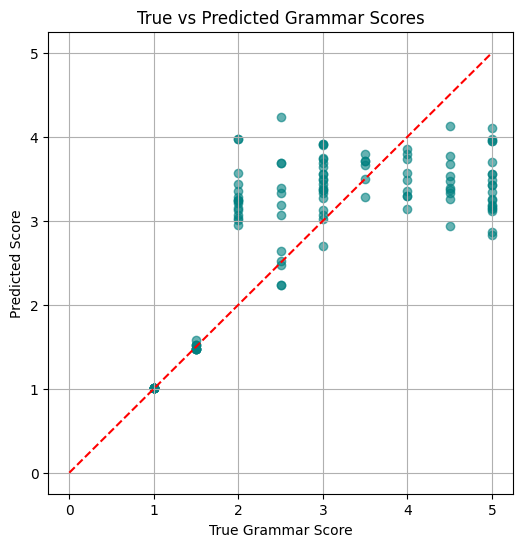

In [ ]:
y_pred = model.predict(X_val).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred, alpha=0.6, color='teal')
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Score")
plt.title("True vs Predicted Grammar Scores")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)


In [ ]:
print(f"RMSE = {rmse:.3f}")
print(f"R²   = {r2:.3f}")

RMSE = 0.973
R²   = 0.457


In [ ]:
X = X.reshape(X.shape[0], -1, 39)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization

## **BI_LSTM MODEL BUILDING**

In [ ]:
model_bilstm = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])),
    BatchNormalization(),
    Dropout(0.4),

    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output: Continuous score (regression)
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model_bilstm.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

history =model_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 3.0344 - mae: 3.0344 - val_loss: 2.6957 - val_mae: 2.6957
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 1.9938 - mae: 1.9938 - val_loss: 2.3319 - val_mae: 2.3319
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - loss: 1.4431 - mae: 1.4431 - val_loss: 2.0179 - val_mae: 2.0179
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - loss: 1.4111 - mae: 1.4111 - val_loss: 1.8480 - val_mae: 1.8480
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 1.2054 - mae: 1.2054 - val_loss: 1.8205 - val_mae: 1.8205
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 1.2258 - mae: 1.2258 - val_loss: 1.6840 - val_mae: 1.6840
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 1.2261 - mae: 1.2261 - val_loss: 1.4206 - val_mae: 1.4206
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 1.0661 - mae: 1.0661 - val_loss: 1.2413 - val_mae: 1.2413
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - lo

## **MODEL EVALUATION**

In [ ]:
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R²   = {r2:.3f}")


MAE  = 0.747
RMSE = 0.973
R²   = 0.457


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model_bilstm.predict(X_val).flatten()

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R²   = {r2:.3f}")

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 380ms/step
MAE  = 0.779
RMSE = 1.046
R²   = 0.373


## **HYBRIDE MODEL CNN AND BI_LSTM MODEL BUILDING**

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model_cnn_bilstm = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_cnn_bilstm.compile(optimizer='adam', loss='mae', metrics=['mae'])
model_cnn_bilstm.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 860, 64)             │           7,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 430, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 430, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,921 (320.00 KB)

 Trainable params: 81,921 (320.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history =model_cnn_bilstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 2.2351 - mae: 2.2351 - val_loss: 1.4554 - val_mae: 1.4554
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.2460 - mae: 1.2460 - val_loss: 1.1848 - val_mae: 1.1848
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.2222 - mae: 1.2222 - val_loss: 1.1270 - val_mae: 1.1270
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.1819 - mae: 1.1819 - val_loss: 1.1444 - val_mae: 1.1444
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.1275 - mae: 1.1275 - val_loss: 1.0382 - val_mae: 1.0382
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.0640 - mae: 1.0640 - val_loss: 1.1756 - val_mae: 1.1756
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 1.0616 - mae: 1.0616 - val_loss: 1.0115 - val_mae: 1.0115
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.0278 - mae: 1.0278 - val_loss: 0.9905 - val_mae: 0.9905
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.007

## **MODEL EVALUATION**

In [ ]:
y_pred = model_cnn_bilstm.predict(X_val).flatten()

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"R²   = {r2:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step
MAE  = 0.853
RMSE = 1.092
R²   = 0.316
